## Correlation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Read Data

In [2]:
data = pd.read_csv('../UNSW_Train.csv')
data.shape

(175341, 44)

### Train - Test Split

In [3]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((140272, 43), (35069, 43))

## Correlation heatmap

<AxesSubplot:>

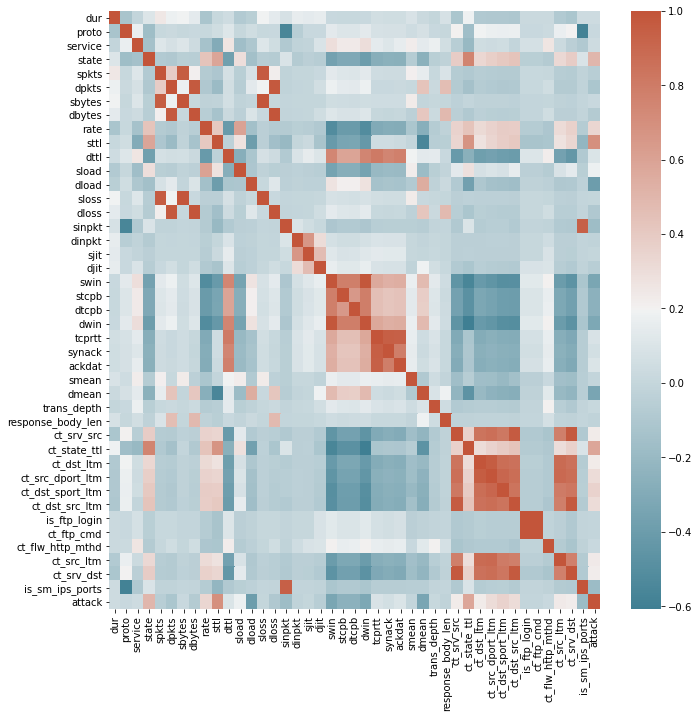

In [4]:
corrmat = X_train.corr(method='pearson')
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat, cmap=cmap)

In the plot above, the dark orange squares correspond to highly correlated features (>0.8). Darker blue squares corresponds to negatively correlated features (<-0.8).

The diagonal represents the correlation of a feature with itself, therefore the value is 1.

We can see that there are a few features that are highly correlated.

## Correlation scatterplots

In [11]:
c = 0
for i in corrmat.loc['sinpkt']:
    if i > 0.8:
        print(corrmat.columns[c], i)
    c = c + 1

sinpkt 1.0
is_sm_ips_ports 0.9412479689254235


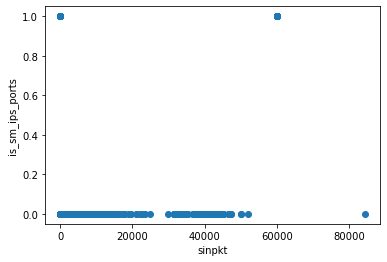

In [12]:
plt.scatter(X_train['sinpkt'], X_train['is_sm_ips_ports'])
plt.ylabel('is_sm_ips_ports')
plt.xlabel('sinpkt')
plt.show()

In [7]:
c = 0
for i in corrmat.loc['sbytes']:
    if i > 0.8:
        print(corrmat.columns[c], i)
    c = c + 1

spkts 0.9605381991783917
sbytes 1.0
sloss 0.9959431707372248


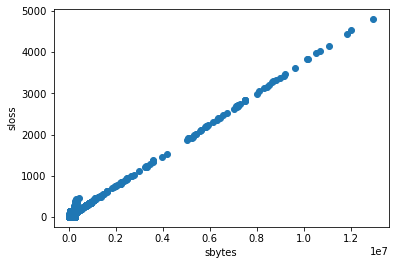

In [8]:
# now, let's plot the variables

plt.scatter(X_train['sbytes'], X_train['sloss'])
plt.ylabel('sloss')
plt.xlabel('sbytes')
plt.show()

We see that the correlation of the second pair of variables is not quite linear.

Next, let's identify a couple of negatively correlated variables:

In [13]:
c = 0
for i in corrmat.loc['dwin']:
    if i <- 0.6:
        print(corrmat.columns[c], i)
        
    c = c + 1

ct_state_ttl -0.6068227431006407


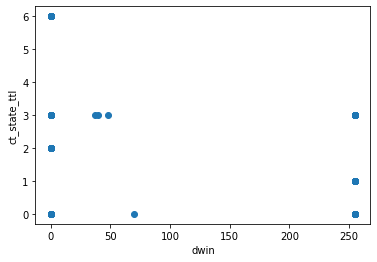

In [14]:
# now, let's plot the variables

plt.scatter(X_train['dwin'], X_train['ct_state_ttl'])
plt.ylabel('ct_state_ttl')
plt.xlabel('dwin')
plt.show()

## Remove correlated

### Brute force approach

In [15]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                col_corr.add(colname)
    return col_corr

In [16]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))

0.9605381991783917 sbytes spkts
0.9739561029095845 dbytes dpkts
0.9684419943017214 sloss spkts
0.9959431707372248 sloss sbytes
0.980622535320131 dloss dpkts
0.9965620563407709 dloss dbytes
0.9903229311759297 dwin swin
0.8088470942288113 tcprtt dttl
0.9483675549910885 synack tcprtt
0.94207653303281 ackdat tcprtt
0.8412820151438404 ct_dst_ltm ct_srv_src
0.8659492346373283 ct_src_dport_ltm ct_srv_src
0.9616787777818492 ct_src_dport_ltm ct_dst_ltm
0.8232968318494978 ct_dst_sport_ltm ct_srv_src
0.8700844280440275 ct_dst_sport_ltm ct_dst_ltm
0.9066919886633623 ct_dst_sport_ltm ct_src_dport_ltm
0.9676650152642573 ct_dst_src_ltm ct_srv_src
0.8523129985838189 ct_dst_src_ltm ct_dst_ltm
0.8704312550386957 ct_dst_src_ltm ct_src_dport_ltm
0.8388847678694561 ct_dst_src_ltm ct_dst_sport_ltm
1.0 ct_ftp_cmd is_ftp_login
0.885629017622687 ct_src_ltm ct_dst_ltm
0.897472221116171 ct_src_ltm ct_src_dport_ltm
0.8028951921898291 ct_src_ltm ct_dst_sport_ltm
0.9802690559763559 ct_srv_dst ct_srv_src
0.852659920

14

We can see that 14 features are highly correlated with other features in the training set. 

Very likely, by removing these correlated features, the performance of your machine learning models will drop very little, if at all. We can go ahead and drop the features like we have done in previous methods.

In [17]:
corr_features

{'ct_dst_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_src_dport_ltm',
 'ct_srv_src',
 'dbytes',
 'dpkts',
 'dttl',
 'is_ftp_login',
 'sbytes',
 'sinpkt',
 'spkts',
 'swin',
 'tcprtt'}

In [18]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((140272, 29), (35069, 29))

By removing correlated columns we reduced the feature space from 16 numerical columns to 14.

### Second approach

The second approach looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [19]:
data = pd.read_csv('../UNSW_Train.csv')
data.shape

(175341, 44)

In [20]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((140272, 43), (35069, 43))

In [21]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,dloss,dbytes,0.996562
1,dbytes,dloss,0.996562
2,sloss,sbytes,0.995943
3,sbytes,sloss,0.995943
4,swin,dwin,0.990323


In [22]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 9 correlated groups
out of 43 total features


In [23]:
for group in correlated_groups:
    print(group)
    print()

  feature1 feature2      corr
0    dloss   dbytes  0.996562
6    dloss    dpkts  0.980623

   feature1 feature2      corr
2     sloss   sbytes  0.995943
15    sloss    spkts  0.968442

  feature1 feature2      corr
4     swin     dwin  0.990323

      feature1          feature2      corr
8   ct_srv_src        ct_srv_dst  0.980269
16  ct_srv_src    ct_dst_src_ltm  0.967665
41  ct_srv_src  ct_src_dport_ltm  0.865949
46  ct_srv_src        ct_dst_ltm  0.841282
52  ct_srv_src  ct_dst_sport_ltm  0.823297

   feature1 feature2      corr
22   synack   tcprtt  0.948368

   feature1 feature2      corr
25   ackdat   tcprtt  0.942077

   feature1         feature2      corr
26   sinpkt  is_sm_ips_ports  0.941248

      feature1          feature2      corr
31  ct_src_ltm  ct_src_dport_ltm  0.897472
33  ct_src_ltm        ct_dst_ltm  0.885629
57  ct_src_ltm  ct_dst_sport_ltm  0.802895

   feature1 feature2      corr
55     dttl   tcprtt  0.808847



In [24]:
group = correlated_groups[1]
group

,feature1,feature2,corr
2,sloss,sbytes,0.995943
15,sloss,spkts,0.968442


Alternatively, we could build a **machine learning algorithm using all the features from the above list, and select the more predictive one**.

In [26]:
from sklearn.ensemble import RandomForestClassifier

# add all features of the group to a list
features = list(group['feature2'].unique())+['sloss']

# train a random forest 
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=39)

In [27]:
# get the feature importance attributed by the random forest model

importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

,feature,importance
0,sbytes,0.441434
1,spkts,0.324002
2,sloss,0.234564


In this case, feature sbytes shows the highest importance according to random forests. Then, I would select Dst_host_serror_rate, and remove all the remaining features from this group from the dataset.

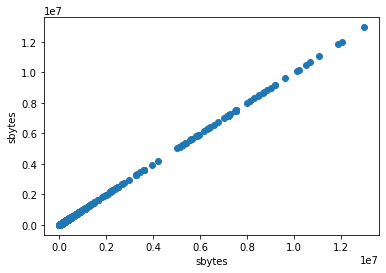

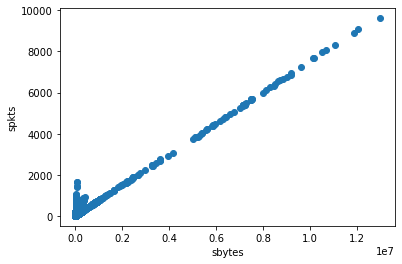

In [28]:
# Plot the correlation of the features in the correlated group from the previous cell

for feature in group['feature2']:
    plt.scatter(X_train['sbytes'], X_train[feature])
    plt.xlabel('sbytes')
    plt.ylabel(feature)
    plt.show()

## Read Data

In [29]:
data = pd.read_csv('../UNSW_Train.csv')
data.shape

(175341, 44)

In [30]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion','ct_dst_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','ct_src_dport_ltm',
                      'ct_srv_src','dbytes','dpkts','dttl','is_ftp_login','sbytes','sinpkt','spkts','swin','tcprtt'],
                       axis=1),         # drop the target and features
    data['is_intrusion'],               # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((140272, 29), (35069, 29))

## Standardize Data

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers

In [32]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression

In [34]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25).fit(X_train, y_train)

CPU times: user 82.1 ms, sys: 166 ms, total: 249 ms
Wall time: 2.92 s


In [35]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.31480795004134704
F1 Score: 0.03726110821747666
FPR: 0.05966565890094256
TPR: 0.019518952273013476


### Naive Bayes

In [36]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-08).fit(X_train, y_train)

CPU times: user 67.5 ms, sys: 14.1 ms, total: 81.6 ms
Wall time: 79.7 ms


In [37]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.7259688043571245
F1 Score: 0.7644492377077308
FPR: 0.1227992174995554
TPR: 0.6545775091298325


### Random Forest

In [38]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000).fit(X_train, y_train)

CPU times: user 1min 13s, sys: 1.2 s, total: 1min 14s
Wall time: 1min 14s


In [39]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
FPR: 1.0
TPR: 1.0


### KNN

In [40]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform').fit(X_train, y_train)

CPU times: user 24.8 s, sys: 174 ms, total: 25 s
Wall time: 24.9 s


In [41]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.6637200946705067
f1: 0.7245977440975222
fpr: 0.30979903965854527
tpr: 0.6512194098140452


### CatBoost

In [42]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.5195696	total: 80.2ms	remaining: 3.93s
1:	learn: 0.3882745	total: 101ms	remaining: 2.42s
2:	learn: 0.2863890	total: 122ms	remaining: 1.91s
3:	learn: 0.2146993	total: 145ms	remaining: 1.66s
4:	learn: 0.1594726	total: 166ms	remaining: 1.49s
5:	learn: 0.1195067	total: 187ms	remaining: 1.37s
6:	learn: 0.0883465	total: 206ms	remaining: 1.27s
7:	learn: 0.0668512	total: 227ms	remaining: 1.19s
8:	learn: 0.0513900	total: 248ms	remaining: 1.13s
9:	learn: 0.0397370	total: 271ms	remaining: 1.08s
10:	learn: 0.0302248	total: 294ms	remaining: 1.04s
11:	learn: 0.0241019	total: 315ms	remaining: 998ms
12:	learn: 0.0190056	total: 338ms	remaining: 961ms
13:	learn: 0.0151359	total: 360ms	remaining: 925ms
14:	learn: 0.0121135	total: 380ms	remaining: 888ms
15:	learn: 0.0098849	total: 401ms	remaining: 852ms
16:	learn: 0.0081654	total: 421ms	remaining: 817ms
17:	learn: 0.0068032	total: 442ms	remaining: 786ms
18:	learn: 0.0057039	total: 463ms	remaining: 755ms
19:	learn: 0.0049007	total: 482ms	remain

In [43]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
FPR: 1.0
TPR: 1.0


## Model Evaluation

In [44]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../UNSW_Test.csv")
test_df.shape

(175341, 44)

In [45]:
# Create feature matrix X and target vextor y
y_eval = test_df['is_intrusion']
X_eval = test_df.drop(columns=['is_intrusion','ct_dst_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','ct_src_dport_ltm',
                               'ct_srv_src','dbytes','dpkts','dttl','is_ftp_login','sbytes','sinpkt','spkts',
                               'swin','tcprtt'])

### Model Evaluation - Logistic Regression


In [46]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=25)
modelLR.fit(X_train, y_train)

LogisticRegression(C=25, n_jobs=-1, random_state=42)

In [47]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [48]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  1.0
Testing accuracy is  0.31480795004134704


In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.31480795004134704
F1 Score: 0.03726110821747666
Precision Score: 0.40933098591549294
Recall Score: 0.019518952273013476
Confusion Matrix:
 [[10575   671]
 [23358   465]]


### Cross validation - Logistic Regression



In [50]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.82523 (+/- 0.17539)
F1 Score: 0.88469 (+/- 0.09468)
Precision: 0.83367 (+/- 0.18289)
Recall: 0.95173 (+/- 0.05768)


### Model Evaluation - Naive Bayes




In [51]:
modelNB = GaussianNB(var_smoothing=1e-08)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-08)

In [52]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [53]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  1.0
Testing accuracy is  0.7259688043571245


In [54]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))

Performance measures for test:
--------
Accuracy: 0.7259688043571245
F1 Score: 0.7644492377077308
Precision Score: 0.9186450662739323
Recall Score: 0.6545775091298325
Confusion Matrix:
 [[ 9865  1381]
 [ 8229 15594]]


### Cross validation - Naive Bayes



In [55]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.81833 (+/- 0.15967)
F1 Score: 0.88188 (+/- 0.08570)
Precision: 0.81241 (+/- 0.15383)
Recall: 0.97092 (+/- 0.03859)


### Model Evaluation - Random Forest




In [56]:
modelRF = RandomForestClassifier(random_state=0,max_depth=100,n_estimators=1000)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=1000, random_state=0)

In [57]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [58]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  1.0
Testing accuracy is  0.6793179161082438


In [59]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
Precision Score: 0.4614728311456469
Recall Score: 0.6793179161082438
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - Random Forest



In [60]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
F1 Score: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)


### Model Evaluation - KNN

In [61]:
modelKNN = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,n_neighbors=5,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1)

In [62]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [63]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9994724535188776
Testing accuracy is  0.6637200946705067


In [64]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.6637200946705067
F1 Score: 0.7245977440975222
Precision Score: 0.8166122749763133
Recall Score: 0.6512194098140452
Confusion Matrix:
 [[ 7762  3484]
 [ 8309 15514]]


### Cross validation - KNN



In [65]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.88073 (+/- 0.12619)
F1 Score: 0.91677 (+/- 0.07390)
Precision: 0.90516 (+/- 0.17164)
Recall: 0.93674 (+/- 0.07591)


### Model Evaluation - CatBoost

In [66]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.5195696	total: 19.9ms	remaining: 975ms
1:	learn: 0.3882745	total: 39.6ms	remaining: 951ms
2:	learn: 0.2863890	total: 59.3ms	remaining: 928ms
3:	learn: 0.2146993	total: 79.5ms	remaining: 915ms
4:	learn: 0.1594726	total: 99.1ms	remaining: 891ms
5:	learn: 0.1195067	total: 119ms	remaining: 873ms
6:	learn: 0.0883465	total: 138ms	remaining: 846ms
7:	learn: 0.0668512	total: 157ms	remaining: 826ms
8:	learn: 0.0513900	total: 178ms	remaining: 809ms
9:	learn: 0.0397370	total: 198ms	remaining: 791ms
10:	learn: 0.0302248	total: 217ms	remaining: 771ms
11:	learn: 0.0241019	total: 237ms	remaining: 751ms
12:	learn: 0.0190056	total: 257ms	remaining: 732ms
13:	learn: 0.0151359	total: 277ms	remaining: 711ms
14:	learn: 0.0121135	total: 296ms	remaining: 691ms
15:	learn: 0.0098849	total: 316ms	remaining: 672ms
16:	learn: 0.0081654	total: 336ms	remaining: 652ms
17:	learn: 0.0068032	total: 356ms	remaining: 632ms
18:	learn: 0.0057039	total: 375ms	remaining: 613ms
19:	learn: 0.0049007	total: 394ms	re

In [67]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [68]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  1.0
Testing accuracy is  0.6793179161082438


In [69]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.6793179161082438
F1 Score: 0.5495955550990522
Precision Score: 0.4614728311456469
Recall Score: 0.6793179161082438
Confusion Matrix:
 [[    0 11246]
 [    0 23823]]


### Cross validation - CatBoost

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.5259567	total: 20ms	remaining: 979ms
1:	learn: 0.3920789	total: 40.1ms	remaining: 963ms
2:	learn: 0.2885022	total: 61.6ms	remaining: 966ms
3:	learn: 0.2156379	total: 83.4ms	remaining: 959ms
4:	learn: 0.1596509	total: 104ms	remaining: 935ms
5:	learn: 0.1192129	total: 125ms	remaining: 915ms
6:	learn: 0.0878755	total: 144ms	remaining: 886ms
7:	learn: 0.0670053	total: 165ms	remaining: 866ms
8:	learn: 0.0512968	total: 186ms	remaining: 847ms
9:	learn: 0.0395079	total: 207ms	remaining: 828ms
10:	learn: 0.0300317	total: 228ms	remaining: 807ms
11:	learn: 0.0234593	total: 248ms	remaining: 786ms
12:	learn: 0.0182602	total: 268ms	remaining: 764ms
13:	learn: 0.0145506	total: 289ms	remaining: 744ms
14:	learn: 0.0116901	total: 309ms	remaining: 721ms
15:	learn: 0.0096609	total: 329ms	remaining: 699ms
16:	learn: 0.0079471	total: 347ms	remaining: 674ms
17:	learn: 0.0065133	total: 368ms	remaining: 654ms
18:	learn: 0.0054662	total: 388ms	remaining: 633ms
19:	learn: 0.0046618	total: 408ms	remai

12:	learn: 0.0184364	total: 274ms	remaining: 781ms
13:	learn: 0.0147073	total: 295ms	remaining: 760ms
14:	learn: 0.0118655	total: 316ms	remaining: 737ms
15:	learn: 0.0095242	total: 337ms	remaining: 716ms
16:	learn: 0.0078815	total: 357ms	remaining: 693ms
17:	learn: 0.0064140	total: 375ms	remaining: 667ms
18:	learn: 0.0053386	total: 396ms	remaining: 646ms
19:	learn: 0.0045848	total: 416ms	remaining: 624ms
20:	learn: 0.0038791	total: 437ms	remaining: 603ms
21:	learn: 0.0033244	total: 456ms	remaining: 581ms
22:	learn: 0.0028424	total: 475ms	remaining: 558ms
23:	learn: 0.0024478	total: 494ms	remaining: 535ms
24:	learn: 0.0021282	total: 513ms	remaining: 513ms
25:	learn: 0.0018543	total: 533ms	remaining: 492ms
26:	learn: 0.0016377	total: 551ms	remaining: 469ms
27:	learn: 0.0014582	total: 569ms	remaining: 447ms
28:	learn: 0.0013052	total: 588ms	remaining: 426ms
29:	learn: 0.0011702	total: 606ms	remaining: 404ms
30:	learn: 0.0010519	total: 626ms	remaining: 384ms
31:	learn: 0.0009514	total: 645

31:	learn: 0.0010166	total: 643ms	remaining: 362ms
32:	learn: 0.0009194	total: 662ms	remaining: 341ms
33:	learn: 0.0008335	total: 681ms	remaining: 320ms
34:	learn: 0.0007669	total: 700ms	remaining: 300ms
35:	learn: 0.0007051	total: 718ms	remaining: 279ms
36:	learn: 0.0006552	total: 737ms	remaining: 259ms
37:	learn: 0.0006093	total: 755ms	remaining: 239ms
38:	learn: 0.0005655	total: 773ms	remaining: 218ms
39:	learn: 0.0005378	total: 790ms	remaining: 198ms
40:	learn: 0.0005014	total: 808ms	remaining: 177ms
41:	learn: 0.0004729	total: 826ms	remaining: 157ms
42:	learn: 0.0004447	total: 846ms	remaining: 138ms
43:	learn: 0.0004210	total: 864ms	remaining: 118ms
44:	learn: 0.0003992	total: 882ms	remaining: 98ms
45:	learn: 0.0003792	total: 898ms	remaining: 78.1ms
46:	learn: 0.0003605	total: 915ms	remaining: 58.4ms
47:	learn: 0.0003429	total: 932ms	remaining: 38.8ms
48:	learn: 0.0003330	total: 947ms	remaining: 19.3ms
49:	learn: 0.0003236	total: 963ms	remaining: 0us
0:	learn: 0.5183393	total: 19.

42:	learn: 0.0004201	total: 859ms	remaining: 140ms
43:	learn: 0.0003971	total: 878ms	remaining: 120ms
44:	learn: 0.0003762	total: 896ms	remaining: 99.6ms
45:	learn: 0.0003565	total: 914ms	remaining: 79.5ms
46:	learn: 0.0003381	total: 931ms	remaining: 59.4ms
47:	learn: 0.0003221	total: 949ms	remaining: 39.5ms
48:	learn: 0.0003061	total: 967ms	remaining: 19.7ms
49:	learn: 0.0002951	total: 985ms	remaining: 0us
0:	learn: 0.5259567	total: 19.9ms	remaining: 975ms
1:	learn: 0.3920789	total: 40.4ms	remaining: 971ms
2:	learn: 0.2885022	total: 61.2ms	remaining: 959ms
3:	learn: 0.2156379	total: 82.5ms	remaining: 949ms
4:	learn: 0.1596509	total: 103ms	remaining: 930ms
5:	learn: 0.1192129	total: 124ms	remaining: 909ms
6:	learn: 0.0878755	total: 144ms	remaining: 883ms
7:	learn: 0.0670053	total: 164ms	remaining: 863ms
8:	learn: 0.0512968	total: 186ms	remaining: 848ms
9:	learn: 0.0395079	total: 207ms	remaining: 828ms
10:	learn: 0.0300317	total: 228ms	remaining: 807ms
11:	learn: 0.0234593	total: 248ms	

10:	learn: 0.0296805	total: 228ms	remaining: 807ms
11:	learn: 0.0233859	total: 249ms	remaining: 789ms
12:	learn: 0.0184364	total: 269ms	remaining: 767ms
13:	learn: 0.0147073	total: 291ms	remaining: 748ms
14:	learn: 0.0118655	total: 311ms	remaining: 726ms
15:	learn: 0.0095242	total: 332ms	remaining: 706ms
16:	learn: 0.0078815	total: 352ms	remaining: 683ms
17:	learn: 0.0064140	total: 370ms	remaining: 658ms
18:	learn: 0.0053386	total: 391ms	remaining: 637ms
19:	learn: 0.0045848	total: 411ms	remaining: 616ms
20:	learn: 0.0038791	total: 432ms	remaining: 596ms
21:	learn: 0.0033244	total: 452ms	remaining: 575ms
22:	learn: 0.0028424	total: 470ms	remaining: 552ms
23:	learn: 0.0024478	total: 489ms	remaining: 530ms
24:	learn: 0.0021282	total: 509ms	remaining: 509ms
25:	learn: 0.0018543	total: 529ms	remaining: 489ms
26:	learn: 0.0016377	total: 548ms	remaining: 467ms
27:	learn: 0.0014582	total: 566ms	remaining: 445ms
28:	learn: 0.0013052	total: 585ms	remaining: 424ms
29:	learn: 0.0011702	total: 604

31:	learn: 0.0010166	total: 649ms	remaining: 365ms
32:	learn: 0.0009194	total: 667ms	remaining: 344ms
33:	learn: 0.0008335	total: 686ms	remaining: 323ms
34:	learn: 0.0007669	total: 705ms	remaining: 302ms
35:	learn: 0.0007051	total: 724ms	remaining: 282ms
36:	learn: 0.0006552	total: 743ms	remaining: 261ms
37:	learn: 0.0006093	total: 761ms	remaining: 240ms
38:	learn: 0.0005655	total: 779ms	remaining: 220ms
39:	learn: 0.0005378	total: 796ms	remaining: 199ms
40:	learn: 0.0005014	total: 814ms	remaining: 179ms
41:	learn: 0.0004729	total: 831ms	remaining: 158ms
42:	learn: 0.0004447	total: 851ms	remaining: 138ms
43:	learn: 0.0004210	total: 869ms	remaining: 119ms
44:	learn: 0.0003992	total: 887ms	remaining: 98.6ms
45:	learn: 0.0003792	total: 904ms	remaining: 78.6ms
46:	learn: 0.0003605	total: 921ms	remaining: 58.8ms
47:	learn: 0.0003429	total: 937ms	remaining: 39.1ms
48:	learn: 0.0003330	total: 954ms	remaining: 19.5ms
49:	learn: 0.0003236	total: 970ms	remaining: 0us
0:	learn: 0.5183393	total: 2

0:	learn: 0.5259567	total: 19.8ms	remaining: 970ms
1:	learn: 0.3920789	total: 41.1ms	remaining: 986ms
2:	learn: 0.2885022	total: 61.8ms	remaining: 968ms
3:	learn: 0.2156379	total: 83.3ms	remaining: 957ms
4:	learn: 0.1596509	total: 104ms	remaining: 933ms
5:	learn: 0.1192129	total: 125ms	remaining: 915ms
6:	learn: 0.0878755	total: 144ms	remaining: 886ms
7:	learn: 0.0670053	total: 165ms	remaining: 866ms
8:	learn: 0.0512968	total: 186ms	remaining: 847ms
9:	learn: 0.0395079	total: 207ms	remaining: 827ms
10:	learn: 0.0300317	total: 228ms	remaining: 807ms
11:	learn: 0.0234593	total: 249ms	remaining: 788ms
12:	learn: 0.0182602	total: 271ms	remaining: 771ms
13:	learn: 0.0145506	total: 292ms	remaining: 752ms
14:	learn: 0.0116901	total: 314ms	remaining: 733ms
15:	learn: 0.0096609	total: 336ms	remaining: 713ms
16:	learn: 0.0079471	total: 355ms	remaining: 689ms
17:	learn: 0.0065133	total: 376ms	remaining: 669ms
18:	learn: 0.0054662	total: 397ms	remaining: 648ms
19:	learn: 0.0046618	total: 418ms	rem

20:	learn: 0.0038791	total: 434ms	remaining: 599ms
21:	learn: 0.0033244	total: 455ms	remaining: 579ms
22:	learn: 0.0028424	total: 473ms	remaining: 555ms
23:	learn: 0.0024478	total: 492ms	remaining: 533ms
24:	learn: 0.0021282	total: 512ms	remaining: 512ms
25:	learn: 0.0018543	total: 532ms	remaining: 491ms
26:	learn: 0.0016377	total: 550ms	remaining: 469ms
27:	learn: 0.0014582	total: 569ms	remaining: 447ms
28:	learn: 0.0013052	total: 588ms	remaining: 426ms
29:	learn: 0.0011702	total: 607ms	remaining: 405ms
30:	learn: 0.0010519	total: 627ms	remaining: 384ms
31:	learn: 0.0009514	total: 646ms	remaining: 363ms
32:	learn: 0.0008701	total: 664ms	remaining: 342ms
33:	learn: 0.0007996	total: 683ms	remaining: 321ms
34:	learn: 0.0007360	total: 702ms	remaining: 301ms
35:	learn: 0.0006811	total: 720ms	remaining: 280ms
36:	learn: 0.0006337	total: 739ms	remaining: 260ms
37:	learn: 0.0005906	total: 757ms	remaining: 239ms
38:	learn: 0.0005506	total: 774ms	remaining: 218ms
39:	learn: 0.0005117	total: 791

41:	learn: 0.0004729	total: 854ms	remaining: 163ms
42:	learn: 0.0004447	total: 874ms	remaining: 142ms
43:	learn: 0.0004210	total: 893ms	remaining: 122ms
44:	learn: 0.0003992	total: 911ms	remaining: 101ms
45:	learn: 0.0003792	total: 927ms	remaining: 80.6ms
46:	learn: 0.0003605	total: 944ms	remaining: 60.3ms
47:	learn: 0.0003429	total: 961ms	remaining: 40ms
48:	learn: 0.0003330	total: 977ms	remaining: 19.9ms
49:	learn: 0.0003236	total: 993ms	remaining: 0us
0:	learn: 0.5183393	total: 20.2ms	remaining: 988ms
1:	learn: 0.3862950	total: 41ms	remaining: 983ms
2:	learn: 0.2841099	total: 61.6ms	remaining: 965ms
3:	learn: 0.2124215	total: 83.1ms	remaining: 956ms
4:	learn: 0.1573845	total: 104ms	remaining: 933ms
5:	learn: 0.1175986	total: 125ms	remaining: 918ms
6:	learn: 0.0872792	total: 145ms	remaining: 891ms
7:	learn: 0.0658658	total: 166ms	remaining: 870ms
8:	learn: 0.0501676	total: 187ms	remaining: 852ms
9:	learn: 0.0384031	total: 208ms	remaining: 834ms
10:	learn: 0.0291518	total: 229ms	remai

10:	learn: 0.0300317	total: 229ms	remaining: 811ms
11:	learn: 0.0234593	total: 249ms	remaining: 789ms
12:	learn: 0.0182602	total: 269ms	remaining: 766ms
13:	learn: 0.0145506	total: 290ms	remaining: 746ms
14:	learn: 0.0116901	total: 310ms	remaining: 724ms
15:	learn: 0.0096609	total: 330ms	remaining: 702ms
16:	learn: 0.0079471	total: 350ms	remaining: 679ms
17:	learn: 0.0065133	total: 370ms	remaining: 658ms
18:	learn: 0.0054662	total: 392ms	remaining: 639ms
19:	learn: 0.0046618	total: 412ms	remaining: 618ms
20:	learn: 0.0040131	total: 432ms	remaining: 596ms
21:	learn: 0.0034266	total: 453ms	remaining: 576ms
22:	learn: 0.0029387	total: 473ms	remaining: 555ms
23:	learn: 0.0025397	total: 492ms	remaining: 533ms
24:	learn: 0.0022069	total: 511ms	remaining: 511ms
25:	learn: 0.0019564	total: 531ms	remaining: 490ms
26:	learn: 0.0017159	total: 550ms	remaining: 469ms
27:	learn: 0.0015127	total: 570ms	remaining: 448ms
28:	learn: 0.0013466	total: 590ms	remaining: 427ms
29:	learn: 0.0012095	total: 610

31:	learn: 0.0009514	total: 648ms	remaining: 364ms
32:	learn: 0.0008701	total: 666ms	remaining: 343ms
33:	learn: 0.0007996	total: 685ms	remaining: 322ms
34:	learn: 0.0007360	total: 704ms	remaining: 302ms
35:	learn: 0.0006811	total: 723ms	remaining: 281ms
36:	learn: 0.0006337	total: 742ms	remaining: 261ms
37:	learn: 0.0005906	total: 760ms	remaining: 240ms
38:	learn: 0.0005506	total: 777ms	remaining: 219ms
39:	learn: 0.0005117	total: 794ms	remaining: 199ms
40:	learn: 0.0004794	total: 812ms	remaining: 178ms
41:	learn: 0.0004524	total: 830ms	remaining: 158ms
42:	learn: 0.0004297	total: 850ms	remaining: 138ms
43:	learn: 0.0004069	total: 869ms	remaining: 118ms
44:	learn: 0.0003863	total: 886ms	remaining: 98.4ms
45:	learn: 0.0003681	total: 904ms	remaining: 78.6ms
46:	learn: 0.0003508	total: 920ms	remaining: 58.7ms
47:	learn: 0.0003342	total: 937ms	remaining: 39ms
48:	learn: 0.0003205	total: 954ms	remaining: 19.5ms
49:	learn: 0.0003067	total: 971ms	remaining: 0us
0:	learn: 0.5259921	total: 20m

42:	learn: 0.0004447	total: 855ms	remaining: 139ms
43:	learn: 0.0004210	total: 873ms	remaining: 119ms
44:	learn: 0.0003992	total: 891ms	remaining: 99ms
45:	learn: 0.0003792	total: 909ms	remaining: 79ms
46:	learn: 0.0003605	total: 926ms	remaining: 59.1ms
47:	learn: 0.0003429	total: 942ms	remaining: 39.3ms
48:	learn: 0.0003330	total: 959ms	remaining: 19.6ms
49:	learn: 0.0003236	total: 975ms	remaining: 0us
0:	learn: 0.5183393	total: 20.3ms	remaining: 993ms
1:	learn: 0.3862950	total: 41.8ms	remaining: 1s
2:	learn: 0.2841099	total: 62.6ms	remaining: 981ms
3:	learn: 0.2124215	total: 85.7ms	remaining: 985ms
4:	learn: 0.1573845	total: 107ms	remaining: 959ms
5:	learn: 0.1175986	total: 127ms	remaining: 934ms
6:	learn: 0.0872792	total: 147ms	remaining: 904ms
7:	learn: 0.0658658	total: 168ms	remaining: 880ms
8:	learn: 0.0501676	total: 189ms	remaining: 862ms
9:	learn: 0.0384031	total: 211ms	remaining: 843ms
10:	learn: 0.0291518	total: 231ms	remaining: 819ms
11:	learn: 0.0227228	total: 253ms	remaini

In [71]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 1.00000 (+/- 0.00000)
F1 Score: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
